In [46]:
import pandas as pd
import numpy as np
import datetime
import string
import os
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
DATA_PATH = '../dataset'
RAW_DATA = os.path.join(DATA_PATH, 'raw_data.csv')
OUT_DATA = os.path.join(DATA_PATH, 'out.csv')

In [3]:
dataset = pd.read_csv(RAW_DATA, keep_default_na=False)

In [4]:
dataset = dataset.rename(columns={"GIOI.x": "Female"})
s = dataset['Female'].to_numpy()

for i in range(len(s)):
    if s[i] == 'Nam' or s[i] == 'M':
        dataset.at[i,'Female'] = 0
    elif s[i] == 'Nu' or s[i] == 'F':
        dataset.at[i,'Female'] = 1

In [5]:
s = dataset['Female'].to_numpy()
male = 0
female = 0
total = dataset.shape[0]
for i in s:
    if i == 0:
        male += 1
    elif i == 1:
        female += 1
unknown = total - male - female
gender = pd.DataFrame([[total,male,female,unknown]], columns=['Total','Male','Female','Unknown'])

In [6]:
  filepath = Path(os.path.join(DATA_PATH, 'gender.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)
gender.to_csv(filepath, index=False)

In [7]:
dataset = dataset.drop(columns=['STT', 'ID', 'Name', 'SODIENTHOAI', 'Fisrt of Department',
                                'Department of out hospital', 'Department of test'])

In [8]:
month_name = ['Jan', 'Feb', 'Mar', 'Apr',
              'May', 'Jun', 'Jul', 'Aug',
              'Sep', 'Oct', 'Nov', 'Dec']

def to_datetime(column_name):
    s = dataset[column_name].to_numpy(dtype = 'str')
    for i in range(len(s)):
        if s[i] == 'nan':
            continue
        if '-' in s[i]:
            date = s[i].split(sep='-')
        elif '/' in s[i]:
            date = s[i].split(sep='/')
        for j in range(len(month_name)):
            if date[1] == month_name[j]:
                date[1] = j+1
        date = [int(x) for x in date]
        if date[0] > 2000: # date[0] is year
            x = datetime.date(date[0],date[1],date[2])
        else:
            if date[2] < 2000:
                date[2] += 2000
            x = datetime.date(date[2],date[1],date[0])
        dataset.at[i,column_name] = x

dataset = dataset.rename(columns={"NGAYSINH.x":"dob"})
to_datetime('dob')
dataset = dataset.rename(columns={"date of admission":"admission_date"})
to_datetime('admission_date')

In [9]:
dataset.insert(7, "age_at_admission", 0)

In [10]:
for i in range(dataset.shape[0]):
    x = dataset.at[i,'dob']
    y = dataset.at[i,'admission_date']
    if pd.isna(dataset.at[i,'dob']) == False and pd.isna(dataset.at[i,'admission_date']) == False:
        z = y - x
        dataset.at[i,"age_at_admission"] = z.days // 30

In [11]:
dataset = dataset.rename(columns={"Distric":"district"})
dis = dataset['district'].to_numpy(dtype='str')

wrong_dis = ["Huyen V_ Quang","ph_ c_","Huyen Hi_p H","Kim B_ng","Huyen H__ng Kh?","Nam Tr_c","Th__ng Xu","T__ng D__ng","Huyen C_ Kuin",
"B_m S_n","Y?n Khnh","Bnh Xuy?n","Huyen Kim __ng","Xun Tr__ng","Tam D__ng","Huyen Qu_nh L_u","Thi Xa Thai Ho?a","Thi Xa Thai Ho`a",
"TP B_c Giang","L__ng S_n","Y?n L_c","Ung B","Huyen Nng C_ng","Kim Thnh","Huyen Di_n Ch","T_ k_","Gia Vi_n","Giao Th_y","TP. Thi Nguy?n",
"L_p Th_ch","L_c Nam","Huyen T_ K_","tp L_ng S_n","tp. Ninh Bnh","Vi_t Tr","Huyen C_m Kh?","Phc Thnh","B_c Quang","Huyen Thanh Ch__ng",
"H_ H","Huyen Bnh Giang","Mai S_n","Huyen Tam Nâ¢ng","Th_y Nguy?n","Tp Thi Bnh","Ngh_a H_ng","_inh H","Thnh ph_ H_i D__ng","TP. Ninh Bnh",
"Ch Linh","TP. Nam __nh","TP.H_ng Y?n","Kinh M_n","Thanh Mi_n","H_ng Nguy?n","Nam Sch","Huyen Ngh_a _","H_u L_c","Nam c__ng","Quang S_n",
"Phc Y?n","Gia Bnh","Huyen _ng H_ng","Y?n M_","ån Thi","V_nh t__ng","Huyen V_n L","L_c H","__ S_n","H Phong","__ng T"]
correction = ["Huyen Vu Quang","Phu Cu","Huyen Hiep Hoa","Kim Bang","Huyen Huong Khe","Nam Truc","Thuong Xuan","Tuong Duong","Huyen Cu Kuin",
"Bim Son","Yen Khanh","Binh Xuyen","Huyen Kim Dong","Xuan Truong","Tam Duong","Huyen Quynh Luu","Thi Xa Thai Hoa","Thi Xa Thai Hoa",
"TP Bac Giang","Luong Son","Yen Lac","Uong Bi","Huyen Nong Cong","Kim Thanh","Huyen Dien Chau","Tu ky","Gia Vien","Giao Thuy","TP Thai Nguyen",
"Lap Thach","Luc Nam","Huyen Tu Ky","TP Lang Son","TP Ninh Binh","Viet Tri","Huyen Cam Khe","Phuc Thanh","Bac Quang","Huyen Thanh Chuong",
"Ha Hoa","Huyen Binh Giang","Mai Son","Huyen Tam Nong","Thuy Nguyen","TP Thai Binh","Nghia Hung","Dinh Hoa","TP Hai Duong","TP Ninh Binh",
"Chi Linh","TP Nam Dinh","TP Hung Yen","Kinh Mon","Thanh Mien","Hung Nguyen","Nam Sach","Huyen Nghia Dan","Hau Loc","Nam Cuong","Quang Son",
"Phuc Yen","Gia Binh","Huyen Dong Hung","Yen My","An Thi","Vinh Tuong","Huyen Van Lam","Loc Ha","Do Son","Hong Phong","Dong Tam"]

for i in range(len(dis)):
    if dis[i] == 'nan':
        dataset.at[i,'district'] = ''
        continue
    for j in range(len(wrong_dis)):
        if dis[i] == wrong_dis[j]:
            dis[i] = correction[j]
            break
    word_dis = dis[i].split(sep = ' ')
    if word_dis[0] == 'Huy_n':
        word_dis[0] = 'Huyen'
    if word_dis[0] == 'TX':
        word_dis[0] = 'Thi Xa'
    new_dis = ' '.join(word_dis)
    dataset.at[i,'district'] = new_dis

In [12]:
dis = dataset['district'].to_numpy(dtype='str')

for i in range(len(dis)):
    if dis[i] == '':
        continue
    dis[i] = string.capwords(dis[i])
    dataset.at[i,'district'] = dis[i]

In [13]:
dataset = dataset.rename(columns={"Province": "province"})
pro = dataset['province'].to_numpy(dtype='str')

for i in range(len(dis)):
    if pro[i] == 'nan':
        continue
    pro[i] = string.capwords(pro[i])
    dataset.at[i,'province'] = pro[i]

In [14]:
dataset = dataset.rename(columns={"Community": "commune"})
comm = dataset['commune'].to_numpy(dtype='str')

for i in range(len(comm)):
    if comm[i] == 'nan':
        continue
    s = ""
    for j in comm[i]:
        if (j>='a' and j<='z') or (j>='A' and j<='Z') or j ==' ' or (j>='0' and j<='9'):
            s += j
    dataset.at[i,'commune'] = s

In [15]:
comm = dataset['commune'].to_numpy(dtype='str')

for i in range(len(comm)):
    if comm[i] == '':
        continue
    comm[i] = string.capwords(comm[i])
    dataset.at[i,'commune'] = comm[i]

In [16]:
dataset.insert(5,"complete_patient_address",np.nan)

In [17]:
for i in range(dataset.shape[0]):
    commune_i = dataset.at[i,'commune']
    district_i = dataset.at[i,'district']
    province_i = dataset.at[i,'province']
    address = []
    if commune_i != '':
        address.append(commune_i)
    if district_i != '':
        address.append(district_i)
    if province_i != '':
        address.append(province_i)
    full_address = ', '.join(address)
    dataset.at[i,'complete_patient_address'] = full_address

In [18]:
dataset = dataset.rename(columns = {"date of out hospital":"discharge_date"})
to_datetime('discharge_date')

In [19]:
dataset.insert(10,'duration_of_stay',np.nan)

In [20]:
for i in range(dataset.shape[0]):
    x = dataset.at[i,'admission_date']
    y = dataset.at[i,'discharge_date']
    if pd.isna(x) == False and pd.isna(y) == False:
        z = y - x
        dataset.at[i,"duration_of_stay"] = z.days

In [21]:
dataset = dataset.drop(columns = ['LOAIXN','Note of time stay in hospital'])

In [22]:
dataset = dataset.rename(columns = {'date of test':'test_date','date of result':'testresult_date'})
to_datetime('test_date')
to_datetime('testresult_date')

In [23]:
dataset = dataset.rename(columns = {'HAI':'healthcare_associated_infection','RSV':'respiratory_syncytical_virus','ADENO':'adenovirus',
'Pertussis':'pertussis','oxygen':'oxygen_cannula','cipap':'CPAP','ventilator':'conventional_mechanical_ventilation',
'HFO ventilator':'hfo_ventilation','ECMOY:AL':'ECMO'})

def YN_to_binary(column_name):
    s = dataset[column_name].to_numpy(dtype='str')
    for i in range(len(s)):
        if s[i] == '' or s[i] == 'nan':
            dataset.at[i,column_name] = 0
            continue
        ls = s[i].lower()
        if ls == 'yes':
            dataset.at[i,column_name] = 1
        elif ls == 'no' or ls == 'na':
            dataset.at[i,column_name] = 0

YN_to_binary('oxygen_cannula')
YN_to_binary('CPAP')
YN_to_binary('pertussis')
YN_to_binary('healthcare_associated_infection')
YN_to_binary('respiratory_syncytical_virus')
YN_to_binary('adenovirus')
YN_to_binary('conventional_mechanical_ventilation')
YN_to_binary('hfo_ventilation')
YN_to_binary('ECMO')

In [24]:
stat = dataset['Stage of discharge'].to_numpy(dtype = 'str')
#print(np.unique(stat))
res = dataset['result of discharge'].to_numpy(dtype = 'str')
#print(np.unique(res))

In [25]:
diseases = pd.DataFrame()
def diseases_data(column_name):
    s = dataset[column_name].to_numpy(dtype = 'int')
    y = 0
    n = 0
    for i in s:
        if i == 1:
            y += 1
        elif i == 0:
            n += 1
    if y + n != len(s):
        print('nan exists')
    row = diseases.shape[1]
    diseases.insert(row,column_name,[n,y])
diseases_data('adenovirus')
diseases_data('pertussis')
diseases_data('healthcare_associated_infection')
diseases_data('respiratory_syncytical_virus')

diseases.rename(index={0:'No',1:'Yes'})

,adenovirus,pertussis,healthcare_associated_infection,respiratory_syncytical_virus
No,1977,2055,2054,2042
Yes,95,17,18,30


In [26]:
from pathlib import Path  
filepath = Path(os.path.join(DATA_PATH, 'diseases.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)  
diseases.to_csv(filepath, index = True)

In [27]:
from datetime import date
def datetime_to_date(column_name):
    for i in range(dataset.shape[0]):
        x = dataset.at[i,column_name]
        y = pd.to_datetime(x)
        z = y.date()
        #print(z)
        dataset.at[i,column_name] = z

datetime_to_date('dob')
datetime_to_date('admission_date')
datetime_to_date('discharge_date')
datetime_to_date('test_date')
datetime_to_date('testresult_date')

In [28]:
dataset = dataset.drop(columns = ['dialysis','Catheter','Onsetto out hospital','ghi chu nguon'])

In [29]:
vacc = dataset['Vaccination'].to_numpy(dtype = 'str')
print(np.unique(vacc))
unique_status = ['','0','1','1 (12/2/2018)','1 (12/22/2018)','2','3','99', '?a khoa qu?c t? H?i Phòng, ?i?u tr? ph?i','d<U+1EE7> mui',
'kham bs lan anh','tiêm 15/9']
convert_status = ['NA',0,1,1,1,2,3,'NA','?','?',2,'?','?']
for i in range(len(vacc)):
    x = vacc[i]

['' '0' '1' '1 (12/2/2018)' '1 (12/22/2018)' '2' '3' '99'
 '?a khoa qu?c t? H?i Phòng, ?i?u tr? ph?i' 'NA' 'd<U+1EE7> mui'
 'kham bs lan anh' 'tiêm 15/9']


In [30]:
dataset = dataset.rename(columns={'Code source': 'place_of_exposure'})

dataset['place_of_exposure'] = dataset['place_of_exposure'].str.lower()

for i in range(len(dataset['place_of_exposure'])):
    code = dataset.at[i, 'place_of_exposure']
    if code in ['suppected nch', 'definitely nch']:
        dataset.at[i, 'place_of_exposure'] = 'NHP'
    elif code in ['suppected other h', 'suppected  other h', 'definitely other h']:
        dataset.at[i, 'place_of_exposure'] = 'Another hospital'
    elif code in ['community']:
        continue

In [31]:
# Calculate number of patients in each place of exposure
in_nhp, in_another_hospital, in_community = 0, 0, 0
total = dataset.shape[0]

for i in dataset['place_of_exposure']:
    if i == 'NHP':
        in_nhp += 1
    elif i == 'Another hospital':
        in_another_hospital += 1
    elif i == 'community':
        in_community += 1
unknown = total - in_nhp - in_another_hospital - in_community
poe = pd.DataFrame([[total, in_nhp, in_another_hospital, in_community, unknown]], columns=['Total', 'NHP', 'Another hospital', 'Community', 'Unknown'])

In [32]:
from pathlib import Path  
filepath = Path(os.path.join(DATA_PATH, 'place_of_exposure.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)  
poe.to_csv(filepath, index=True)

In [33]:
dataset.insert(20,'complication-gastroentiritis',0)

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    if 'tieu chay' in x:
        dataset.at[i,'complication-gastroentiritis'] = 1

In [34]:
dataset.insert(21,'complication-middle-ear-infec',0)

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    y = dataset.at[i,'Dianogis out of hospital']
    z = dataset.at[i,'Dianogis of test']
    if 'viem tai' in x or 'viem tai' in y or 'viem tai' in z:
        dataset.at[i,'complication-middle-ear-infec'] = 1

In [35]:
dataset.insert(22,'complication-conjunctivitis',0)

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    y = dataset.at[i,'Dianogis out of hospital']
    z = dataset.at[i,'Dianogis of test']
    if 'ket mac' in x or 'ket mac' in y or 'ket mac' in z:
        dataset.at[i,'complication-conjunctivitis'] = 1

In [36]:
dataset.insert(23,'complication-laryngitis',0)

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    y = dataset.at[i,'Dianogis out of hospital']
    z = dataset.at[i,'Dianogis of test']
    t = dataset.at[i,'Dianogis of admission']  
    if 'thanh quan' in x or 'thanh quan' in y or 'thanh quan' in z or 'thanh quan' in t:
        dataset.at[i,'complication-laryngitis'] = 1

In [37]:
dataset.insert(24,'complication-pneumonia-bronchitis',0)
key_word = ['viem phoi', 'viem phe quan','phe quan']

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    y = dataset.at[i,'Dianogis out of hospital']
    z = dataset.at[i,'Dianogis of test']
    t = dataset.at[i,'Dianogis of admission']
    for word in key_word:
        if word in x or word in y or word in z or word in t:
            dataset.at[i,'complication-pneumonia-bronchitis'] = 1  
            break

In [38]:
dataset.insert(25,'complication-febrile-seizures',0)

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    y = dataset.at[i,'Dianogis out of hospital']
    z = dataset.at[i,'Dianogis of test']
    t = dataset.at[i,'Dianogis of admission']
    if 'dong kinh' in x or 'dong kinh' in y or 'dong kinh' in z or 'dong kinh' in t:
        dataset.at[i,'complication-febrile-seizures'] = 1

In [39]:
dataset.insert(26,'complication-septic-shock-sepsis',0)
key_word = ['nhiem khuan huyet', 'soc nhiem khuan']

for i in range(dataset.shape[0]):
    x = dataset.at[i,'complication']
    y = dataset.at[i,'Dianogis out of hospital']
    z = dataset.at[i,'Dianogis of test']
    t = dataset.at[i,'Dianogis of admission']
    for word in key_word:
        if word in x or word in y or word in z or word in t:
            dataset.at[i,'complication-septic-shock-sepsis'] = 1

In [40]:
dataset.insert(27,'co-infection-influenza-a',0)
target_column = ['complication','Dianogis out of hospital','Dianogis of test','Dianogis of admission']

for i in range(dataset.shape[0]):
    for j in target_column:
        x = dataset.at[i,j].lower()
        if 'cum a' in x:
            dataset.at[i,'co-infection-influenza-a'] = 1
            break

In [41]:
for i in range(dataset.shape[0]):
    vaccination_status = dataset.at[i, 'Vaccination']
    if vaccination_status.isnumeric():
            if int(vaccination_status) > 3:
                dataset.at[i, 'Vaccination'] = 'NA'
    else:
        dataset.at[i, 'Vaccination'] = 'NA'

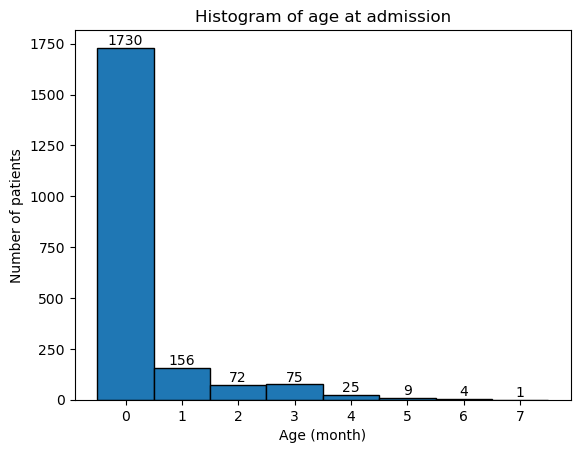

In [ ]:
month_at_admission = dataset['age_at_admission'].to_numpy() // 30
max_month = np.max(month_at_admission)
val,bin = np.histogram(month_at_admission, bins=np.arange(max_month+2))

fig, ax = plt.subplots()

# Set title, add labels
ax.set_title("Histogram of age at admission")
ax.set_xlabel('Age (month)')
ax.set_ylabel('Number of patients')

# can add log = 'True' for better visualization
ax.hist(month_at_admission,bins = np.arange(max_month+2),align='left',edgecolor='black',label='Age at admission')
rects = ax.patches
  
for rect, label in zip(rects, val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, ha='center', va='bottom')

plt.show()

In [55]:
duration_of_stay = dataset['duration_of_stay'].to_numpy()

# don't need box plots yet
#plt.boxplot(duration_of_stay,showmeans=True,vert=False)
#plt.show()

min_duration = np.min(duration_of_stay)
max_duration = np.max(duration_of_stay)
mean_duration = np.mean(duration_of_stay)
median_duration = np.median(duration_of_stay)
first_quartile_duration = np.percentile(duration_of_stay,25)
third_quartile_duration = np.percentile(duration_of_stay,75)

print('Min duration: ',min_duration)
print('Max duration: ',max_duration)
print('Mean duration: ',mean_duration)
print('Median duration: ',median_duration)
print('First quartile: ',first_quartile)
print('Third quartile: ',third_quartile)

duration_group = [0,3,8,15]
occurance_of_duraion_group = [0] * 4

for i in duration_of_stay:
    for j in range(3,-1,-1):
        if i >= duration_group[j]:
            occurance_of_duraion_group[j] += 1
            break

stay_duration = pd.DataFrame([occurance_of_duraion_group], columns=['< 3','3 - 7','8 - 14','> 14'])

Min duration:  1.0
Max duration:  170.0
Mean duration:  11.445945945945946
Median duration:  6.0
First quartile:  4.0
Third quartile:  12.0


In [44]:
filepath = Path(os.path.join(DATA_PATH, 'duration_of_stay.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)
stay_duration.to_csv(filepath, index=False)

[1 0 0 ... 0 0 1]
Min test duration: 0
Max test duration: 5
Mean test duration: 0.7065637065637066
Median test duration: 1.0
First quartile test duration: 0.0
Third quartile test duration: 1.0


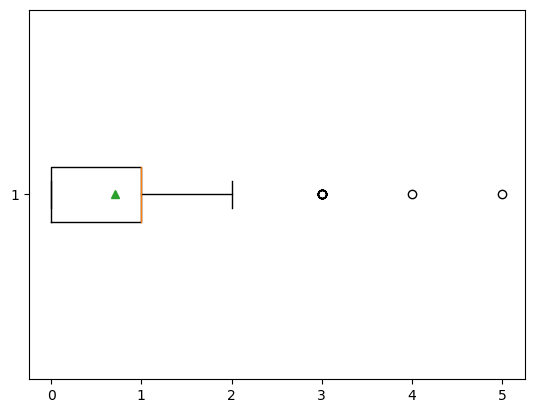

[796, 1106, 155, 15]


In [62]:
test_date_to_test_result = dataset['testresult_date'].to_numpy() - dataset['test_date'].to_numpy()
for i in range(len(test_date_to_test_result)):
    test_date_to_test_result[i] = test_date_to_test_result[i].days

min_test_duration = np.min(test_date_to_test_result)
max_test_duration = np.max(test_date_to_test_result)
mean_test_duration = np.mean(test_date_to_test_result)
median_test_duration = np.median(test_date_to_test_result)
first_quartile_test = np.percentile(test_date_to_test_result,25)
third_quartile_test = np.percentile(test_date_to_test_result,75)

print('Min test duration:',min_test_duration)
print('Max test duration:',max_test_duration)
print('Mean test duration:',mean_test_duration)
print('Median test duration:',median_test_duration)
print('First quartile test duration:',first_quartile_test)
print('Third quartile test duration:',third_quartile_test)

plt.boxplot(test_date_to_test_result,showmeans=True,vert=False)
plt.show()

day_group = [0,1,2,3]
occurance_of_day_group = [0] * 4

for i in test_date_to_test_result:
    for j in range(3,-1,-1):
        if i >= day_group[j]:
            occurance_of_day_group[j] += 1
            break

print(occurance_of_day_group)
test_duration = pd.DataFrame([occurance_of_day_group], columns=['0','1','2','> 2'])

In [53]:
filepath = Path(os.path.join(DATA_PATH, 'duration_of_test.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)
test_duration.to_csv(filepath, index=False)

In [45]:
filepath = Path(OUT_DATA)
filepath.parent.mkdir(parents=True, exist_ok=True)
dataset.to_csv(filepath, index=False)